# Determining ERA5 climatology

## ERA5 climatology for deepsoiltemperture CCLM
Problem:
T_Cl in the extpar of cclm is (presumably) the reason for the cold bias in all cclm runs.
Therefore, we are investigating how other datasets could contribute to a smaller cold bias.

==> Current to do:
- Determine climatology of ERA5 soil layer 4
- Average, mean, max over 30 year periods
- Comparison with GLOBECOVER extpar and ECOCLIMAP extpar

In [92]:
import sys
parent_directory = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/fiens/ValEnsPy/evaluation_cclm/'
sys.path.append(parent_directory)
functions_directory = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/fiens/ValEnsPy/src/valenspy/'
sys.path.append(functions_directory)

from pathlib import Path

import xarray as xr
import pandas as pd

import valenspy as vp #The Valenspy package
from valenspy.inputconverter_functions import ERA5_to_CF, CCLM_to_CF
from valenspy._utilities import load_xarray_from_data_sources
from valenspy._regions import sel_region
from diagnostic_visualizations import *
from eval_functions import *
from yaml import safe_load

import numpy as np
import matplotlib.pyplot as plt

In [93]:
def geo_to_rot(coord, ds):
    ###
    # Converts a geographic (lon,lat) point to an (rlon,rlat) point
    # => coord: geographic lon - lat couple (degrees) => list or tuple
    # => ds: xarray dataset of a CCLM file
    ###
    # Read in COSMO-CLM data

    rp_lat = float(ds.rotated_pole.grid_north_pole_latitude)
    rp_lon = float(ds.rotated_pole.grid_north_pole_longitude)
    # Convert 
    co = np.deg2rad(coord)
    rp_lat = np.deg2rad(rp_lat); rp_lon = np.deg2rad(rp_lon)
    p_rlat = np.arcsin(np.sin(co[1])*np.sin(rp_lat) + np.cos(co[1])*np.cos(rp_lat)*np.cos(co[0]-rp_lon)) 
    p_rlon = np.arctan((np.cos(co[1])*np.sin(co[0]-rp_lon)) / (np.cos(co[1])*np.sin(rp_lat)*np.cos(co[0]-rp_lon) - np.sin(co[1])*np.cos(rp_lat))) 
    p_rlat = np.rad2deg(p_rlat); p_rlon = np.rad2deg(p_rlon)
    # Return rlon-rlat couple
    return [p_rlon,p_rlat]

In [94]:
machine = "hortense"
variable = "stl4"
ref_dataset = "ERA5"
startyear = 1961
endyear = 1990
method = 'mean'

In [95]:
# Loading ECOCLIMAP data
ec_dir = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/wouterl/exp_fiens_eval_setup_JJA1995_transient_aerosol_ECOCLIMAP/ext/'
ec_file = ec_dir + 'extpar_1995.nc'
ec_extp = xr.open_mfdataset(ec_file, combine="by_coords", chunks="auto")


In [96]:
# Loading ECOCLIMAP data
gc_dir = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/wouterl/exp_fiens_eval_setup_JJA1995_transient_aerosol/ext/'
gc_file = gc_dir + 'extpar_1995.nc'
gc_extp = xr.open_mfdataset(gc_file, combine="by_coords", chunks="auto")

In [97]:
# ERA5 files (manually loaded and converted)
data_dir = '/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/soil_temperature_level_4/'
ERA5_deepsoil_files = os.listdir(data_dir)


In [98]:
# Processing data into file with averages
# Filtering climatology files based on year range
climatology_files = [
    s for s in ERA5_deepsoil_files 
    if startyear <= int(s[-7:-3]) <= endyear
]



In [99]:
# Calculating climatology statistics
# List all NetCDF files in the directory



In [100]:
# define bounds 
bounds = {'europe':
                    {'lat_bounds': [70,35], 
                    'lon_bounds': [-15,40]}, 
        'belgium': 
                    {'lat_bounds': [52,49], 
                    'lon_bounds': [2,7]}}

In [101]:
# region = 'belgium'
# lat_bounds = bounds[region]['lat_bounds']
# lon_bounds = bounds[region]['lon_bounds']
# ds = ds.rename({'latitude' : 'lat', 'longitude' : 'lon', 'valid_time' : 'time'})
# ds = ds.sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0], lat_bounds[1]))


In [102]:
savepath = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/ERA5/'
filename = ref_dataset + '_' + variable + '_' + str(startyear) + '-' + str(endyear) + '_' + method + '.nc'
if os.path.exists(savepath + filename):
    print(f"The file '{filename}' already exists.")
    ds = xr.open_mfdataset(savepath + filename)
    #da = ds.to_array()
else:
    netcdf_files = [os.path.join(data_dir, f) for f in climatology_files]
    # Open multiple NetCDF files as a single xarray dataset
    ds = xr.open_mfdataset(netcdf_files, combine='by_coords', engine='netcdf4', chunks="auto")
    ds = ds.rename({'latitude' : 'lat', 'longitude' : 'lon', 'valid_time' : 'time'})
    ds = ds.sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0], lat_bounds[1]))
    if method == 'min':
        print('min')
        da = ds['stl4'].min('time').compute()
    elif method == 'mean':
        da = ds['stl4'].mean('time').compute()
    elif method == 'max':
        da = ds['stl4'].max('time').compute()
    elif method == 'P10':
        da = ds['stl4'].quantile(q = 10, dim = 'time').compute()
    else:
        print("Method is not included")
    da.to_netcdf(savepath + filename)


#plot_map(da)

The file 'ERA5_stl4_1961-1990_mean.nc' already exists.


In [103]:
da = ds['stl4']
da

<xarray.DataArray 'stl4' (lat: 163, lon: 289)> Size: 188kB
dask.array<open_dataset-stl4, shape=(163, 289), dtype=float32, chunksize=(163, 289), chunktype=numpy.ndarray>
Coordinates:
    number   int64 8B ...
  * lat      (lat) float64 1kB 73.5 73.25 73.0 72.75 ... 33.75 33.5 33.25 33.0
  * lon      (lon) float64 2kB -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
Attributes: (12/32)
    GRIB_paramId:                             236
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      47107
    GRIB_typeOfLevel:                         depthBelowLandLayer
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Soil temperature level 4
    units:                                    K
    standard_name:                            unknown
    GRIB_depthBelowLandLayer:                 100.0

In [104]:
gridfile = data_dir + climatology_files[0]
da_ec_extp_soil = ec_extp["T_CL"]
ec_remap = remap_cdo(ds = da_ec_extp_soil, target_grid = gridfile, remap_method="bil")


In [105]:
da_ec_remap = ec_remap['T_CL']
da_ec_remap.attrs['long_name'] = 'Deepsoil Temperature'
da_ec_remap.attrs['units'] = 'K'
da_ec_remap.attrs['dataset'] = 'CRU'
# da_ec_remap = ec_remap.to_array()

da.attrs['dataset'] = method + ' ERA5 level4'

In [106]:
da_diff = da_ec_remap - da
da_diff

<xarray.DataArray (lat: 163, lon: 289)> Size: 188kB
dask.array<sub, shape=(163, 289), dtype=float32, chunksize=(163, 289), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 2kB -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * lat      (lat) float64 1kB 33.0 33.25 33.5 33.75 ... 72.75 73.0 73.25 73.5
    number   int64 8B ...
Attributes:
    standard_name:  soil_temperature
    long_name:      Deepsoil Temperature
    units:          K
    data_set:       CRU
    dataset:        CRU

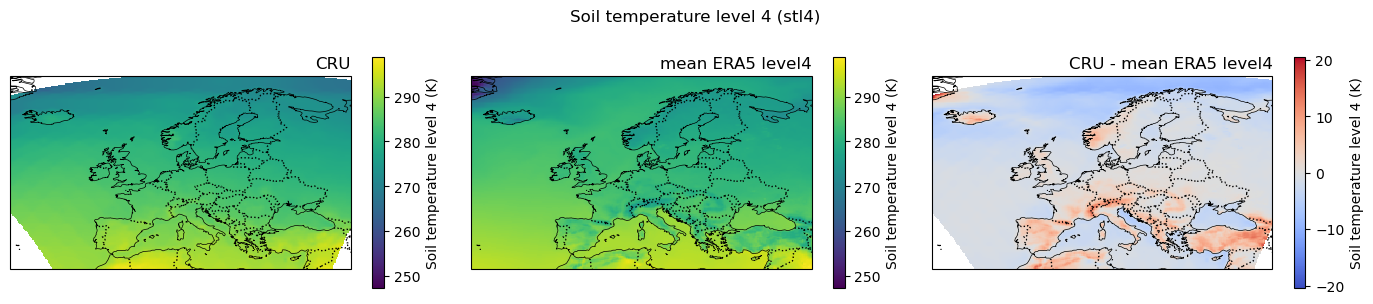

In [107]:
ax = plot_maps_mod_ref_diff(da_ref = da,  da_mod = da_ec_remap,  da_diff = da_diff)

In [108]:
region = 'belgium'
lat_bounds = bounds[region]['lat_bounds']
lon_bounds = bounds[region]['lon_bounds']

In [109]:
da = da.sortby('lat')
da

<xarray.DataArray 'stl4' (lat: 163, lon: 289)> Size: 188kB
dask.array<getitem, shape=(163, 289), dtype=float32, chunksize=(163, 289), chunktype=numpy.ndarray>
Coordinates:
    number   int64 8B ...
  * lat      (lat) float64 1kB 33.0 33.25 33.5 33.75 ... 72.75 73.0 73.25 73.5
  * lon      (lon) float64 2kB -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
Attributes: (12/33)
    GRIB_paramId:                             236
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      47107
    GRIB_typeOfLevel:                         depthBelowLandLayer
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_units:                               K
    long_name:                                Soil temperature level 4
    units:                                    K
    standard_name:                            unknown
    GRIB_depthBelowLandLayer:                 100.0
    dataset:                                  mean ERA5 level4

In [110]:
da_region = sel_region(da, region=region)
da_region


<xarray.DataArray 'stl4' (lat: 13, lon: 21)> Size: 1kB
dask.array<getitem, shape=(13, 21), dtype=float32, chunksize=(13, 21), chunktype=numpy.ndarray>
Coordinates:
    number   int64 8B ...
  * lat      (lat) float64 104B 49.0 49.25 49.5 49.75 ... 51.25 51.5 51.75 52.0
  * lon      (lon) float64 168B 2.0 2.25 2.5 2.75 3.0 ... 6.0 6.25 6.5 6.75 7.0
Attributes: (12/33)
    GRIB_paramId:                             236
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      47107
    GRIB_typeOfLevel:                         depthBelowLandLayer
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_units:                               K
    long_name:                                Soil temperature level 4
    units:                                    K
    standard_name:                            unknown
    GRIB_depthBelowLandLayer:                 100.0
    dataset:                                  mean ERA5 level4

In [111]:
da_ec_remap_region = sel_region(da_ec_remap, region=region)

da_ec_remap_region.attrs['long_name'] = 'Deepsoil Temperature'
da_ec_remap_region.attrs['units'] = 'K'
da_ec_remap_region.attrs['dataset'] = 'CRU'

In [112]:
da_diff_region = da_ec_remap_region - da_region
da_diff_region


<xarray.DataArray (lat: 13, lon: 21)> Size: 1kB
dask.array<sub, shape=(13, 21), dtype=float32, chunksize=(13, 21), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 168B 2.0 2.25 2.5 2.75 3.0 ... 6.0 6.25 6.5 6.75 7.0
  * lat      (lat) float64 104B 49.0 49.25 49.5 49.75 ... 51.25 51.5 51.75 52.0
    number   int64 8B ...
Attributes:
    standard_name:  soil_temperature
    long_name:      Deepsoil Temperature
    units:          K
    data_set:       CRU
    dataset:        CRU

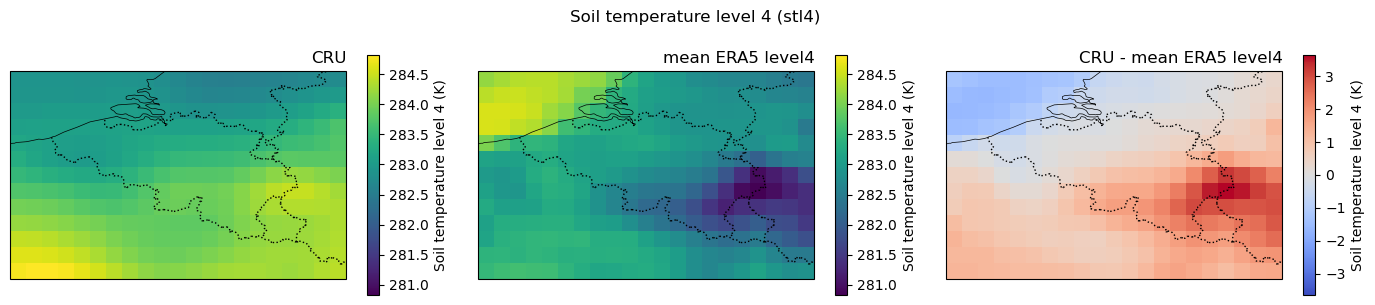

In [113]:
ax = plot_maps_mod_ref_diff(da_ref = da_region,  da_mod = da_ec_remap_region,  da_diff = da_diff_region)